<h2>Data download and some preprocessing</h2>

In [1]:
###############
## This section is used to download the data files
###############

import requests
import urllib.request
import os
from tqdm.notebook import tqdm
import re

def download_isd_for_year(year, datadir, pattern = "href=.*?.gz", maxnum = float("inf")):
    ### Download all the data for a given year and store in the specified directory
    # PARAMETERS:
    # ------------
    # year: year number e.g. 2021
    # datadir: output directory. This will be appended by the year in the function
    # pattern: (optional) pattern of filename in a regex format. Should start with 'href="'
    # maxnum: (optional) maximum number of files to download; if not provided or bigger than
    url = f"https://www1.ncdc.noaa.gov/pub/data/noaa/isd-lite/{year}"
    datadir = f"{datadir}/{year}"
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    r = requests.get(url)
    filenames = re.findall(pattern, r._content.decode("ascii"))
    filenames = [fname[len('href="'):] for fname in filenames]
    filenames = filenames[:min(maxnum, len(filenames))]
    filenames = set(filenames)
    print(f"downloading {len(set(filenames))}...")
    [urllib.request.urlretrieve(f"{url}/{fname}", f"{datadir}/{fname}") for fname in tqdm(filenames)]
    
download_dir = "data"
years = [2015,2016, 2017, 2019, 2021]
pattern = 'href="[0-3]{2}.*?.gz'
# UNCOMMENT THE NEXT TWO LINES TO DOWNLOAD THE DATA
#for year in tqdm(years):
#    download_isd_for_year(year, "data", maxnum = 10000)

In [2]:
###########################
# This section provides a functions for reformatting the data to make it readable by pandas
##########################

import os 

def reformat_files(dirname):
    ### Reformats all files in a given directory, creates a subdirectory, and writes the reformatted file there.
    # The reformatting is done by replacing one or more space characters with a comma
    # assumes all files in the directory should be reformatted and that they are zipped files
    
    # PARAMETERS:
    # ---------------
    # input directory path
    
    filenames = os.listdir(dirname)
    outdir = f"{dirname}/unzipped"
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    for fname in filenames:
        os.system(f"zcat {dirname}/{fname} | sed -r 's/ +/,/g' > {outdir}/{fname[:-3]}")
        
dirname = "data/2020"
# UNCOMMENT THE NEXT LINE TO REFORMAT THE DOWNLOADED DATA FOR 2020
#reformat_files(dirname)

In [3]:
### THIS SECTION DOWNLOADS THE isd-history.csv file

import urllib.request
hist_file = "https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv"
urllib.request.urlretrieve(hist_file, f"data/isd-history.csv")

('data/isd-history.csv', <http.client.HTTPMessage at 0x7f22f46a30d0>)

<h2> Checking the ISD history file </h2>

In [4]:
import pandas as pd
h = pd.read_csv("data/isd-history.csv")
h.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,20140923,20150926
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,20050101,20120731
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,20100519,20120323


In [5]:
print("number of sensors listed in history file:", h.shape[0])

number of sensors listed in history file: 29605


In [6]:
print("Checking number of missing values in each column:")
pd.DataFrame(h.isnull().sum()).transpose()

Checking number of missing values in each column:


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,0,0,790,895,22987,18808,1186,1187,1290,0,0


State and ICAO are missing from quite a number of rows. Ctry is missing from some as well, along with elevation.  
Next I'll try to see how the distances between the sensors are distributed and cluster them so I can select a subset of sensors based on their geography.

In [7]:
import numpy as np
from scipy.spatial import distance_matrix
#computing the distance matrix between all sensors
h = h.dropna(axis = 0, subset = ['LAT', 'LON'])
dists = distance_matrix(h[['LAT','LON']], h[['LAT','LON']])

#computing 0.05x quartiles of the distances (i.e. 5%, 10%, 15%, ...) 
dist_quartiles = np.nanquantile(dists, np.arange(0,1, 0.05))

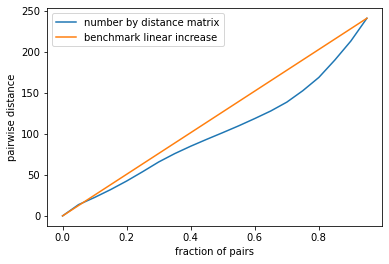

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,1,0.05), dist_quartiles, label = "number by distance matrix")
plt.plot(np.arange(0,1,0.05), np.arange(0,max(dist_quartiles)+1, max(dist_quartiles) / 19), label = "benchmark linear increase")
plt.ylabel("pairwise distance")
plt.xlabel("fraction of pairs")
plt.legend()

The distance between points (sensors) seem to be increasing linearly (maybe slightly sub-linear). This means using a clustering algorithm like dbscan will not generate much meaningful results. To illustrate this uncomment the box below and run it. Instead, we will use kmeans clustering, finding the number of clusters by elbow method.

In [9]:
#%%capture
#%pip install geopandas
#import geopandas
#from sklearn.cluster import DBSCAN

#c = DBSCAN(eps = 11).fit(h[['LAT', 'LON']].dropna())
#np.unique(c.labels_)
#geourl = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
#worldmap = geopandas.read_file(geourl)
#fig, ax = plt.subplots(figsize=(12,10))
#worldmap.plot(ax = ax)
#ax.scatter(h['LON'], h['LAT'], c = h['cluster'])

We will call kmeans multiple time with differen k-s and plot the inertia vs k, to select a good k.

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f210ede54c0>
Traceback (most recent call last):
  File "/home/armen/software/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/armen/software/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/armen/software/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/armen/software/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_w

    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


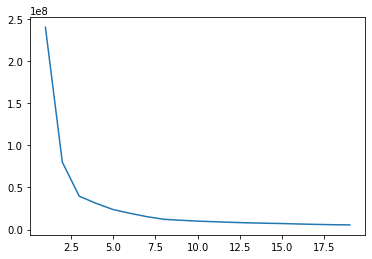

In [10]:
from sklearn.cluster import KMeans
inertias = []
krange = range(1,20)
for k in krange:
    c = KMeans(k).fit(h[['LAT', 'LON']].dropna())
    inertias.append(c.inertia_)
plt.plot(krange, inertias)

Based on the elbow method we will select k=6 (well, I first selected 5 but then changed it to 6 once I checked the map!)

In [11]:
%%capture
%pip install geopandas

No handles with labels found to put in legend.


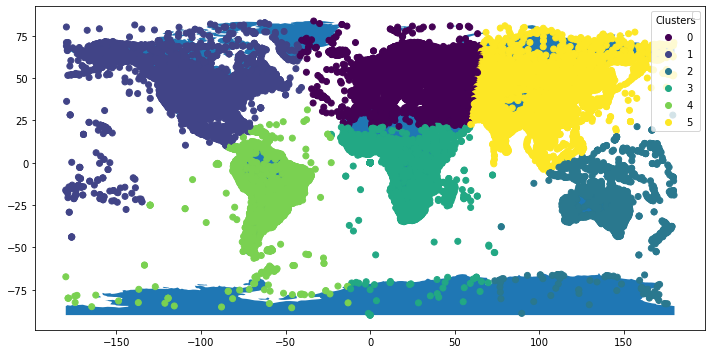

In [12]:
import geopandas
k = 6
c = KMeans(k, random_state = 0).fit(h[['LAT', 'LON']].dropna())
h = h.dropna(axis = 0, subset = ['LAT', 'LON'])
h['cluster'] = c.labels_
geourl = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
worldmap = geopandas.read_file(geourl)
fig, ax = plt.subplots(figsize=(12,10))
worldmap.plot(ax = ax)
scatter = ax.scatter(h['LON'], h['LAT'], c = h['cluster'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.legend()

Cluster labels are assigned based on the map above to continents.  
Now, checking number of countries per cluster:

In [13]:
h['cluster'] = pd.Categorical(h.cluster)
h.replace([0,1,2,3,4,5], ["Europe", "North America", "Oceania", "Africa", "South America", "Asia"], inplace = True)
h['continent'] = h.cluster
pd.DataFrame(h.groupby('cluster').CTRY.nunique()).transpose()

cluster,Africa,Asia,Europe,North America,Oceania,South America
CTRY,91,37,86,43,26,46


it's interesting why do we have 26 CTRY in Oceania for example, if we don't have as many countries there? let's check.

In [14]:
h[h['cluster'] == "Oceania"]

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,cluster,continent
13927,671980,99999,ILE AMSTERDAM,FS,NaN,NaN,-37.833,77.567,28,19500201,20210502,Oceania,Oceania
14892,695023,99999,HORN ISLAND (HID),AS,NaN,KQXC,-10.583,142.3,NaN,19420804,20030816,Oceania,Oceania
15358,702759,99999,KOROR,PS,NaN,PTKR,7.333,134.483,30,20040608,20081231,Oceania,Oceania
22120,749307,99999,A.B.WON PAT AIRPORT,PS,NaN,NaN,6.9,134.15,6,19441015,19450610,Oceania,Oceania
22121,749308,99999,PULAU FANI,ID,NaN,NaN,1.083,131.267,Oceania,19441129,19450210,Oceania,Oceania
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29347,999999,87603,HUT POINT,AY,NaN,NaN,-77.883,166.733,25.9,19621004,19621231,Oceania,Oceania
29348,999999,87701,ADARE HALLETT,AY,NaN,NaN,-72.3,170.217,4.9,19570131,19730215,Oceania,Oceania
29349,999999,88701,LIV,AY,NaN,NaN,-83.283,175.75,182.9,19571109,19571130,Oceania,Oceania
29350,999999,88702,BEARDMORE CAMP,AY,NaN,NaN,-83.4,174.75,59.1,19601108,19640227,Oceania,Oceania


The first country code that we see assigned to Oceania is FS. It seems like it refers to French Southern and Antarctic lands. Then we have AY for Antarctica itself, and AS for Austrialia. I haven't figured out where PS is. Either way, this gives some clarity.

how many sensors are there per cluster:

In [15]:
sensor_count = pd.DataFrame(h.cluster.value_counts()).transpose()
sensor_count.index = ["sensor_count"]
sensor_count

,North America,Europe,Asia,South America,Oceania,Africa
sensor_count,9675,7880,4967,2030,2020,1846


In [16]:
h['begin_year'] = h['BEGIN'].astype(str).str.slice(0,4).astype(int)
h['end_year'] = h['END'].astype(str).str.slice(0,4).astype(int)
h["in_use_years"] = h['end_year'] - h['begin_year']
h.sort_values(['begin_year', 'in_use_years'])
h.loc[(h['begin_year'] < 1950) & (h['cluster'] == "Europe") & (h['in_use_years'] > 30)]

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,cluster,continent,begin_year,end_year,in_use_years
11,010010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9,19310101,20220218,Europe,Europe,1931,2022,91
20,010050,99999,ISFJORD RADIO,SV,NaN,NaN,78.067,13.633,9,19310103,20041030,Europe,Europe,1931,2004,73
26,010100,99999,ANDOYA,NO,NaN,ENAN,69.293,16.144,13.1,19310103,20220218,Europe,Europe,1931,2022,91
36,010230,99999,BARDUFOSS,NO,NaN,ENDU,69.056,18.54,76.8,19400713,20220218,Europe,Europe,1940,2022,82
42,010280,99999,BJORNOYA ISLAND,NO,NaN,ENBJ,74.517,19.017,18,19310103,20220218,Europe,Europe,1931,2022,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13265,624590,99999,EL TOR,EG,NaN,HETR,28.209,33.646,35.1,19381101,20220218,Europe,Europe,1938,2022,84
13266,624620,99999,JIYANKLIS NEW,EG,NaN,HEGS,30.82,30.191,14.9,19490301,20110501,Europe,Europe,1949,2011,62
13270,624650,99999,KOSSEIR,EG,NaN,NaN,26.133,34.25,11,19381002,20220215,Europe,Europe,1938,2022,84
13280,626000,99999,HALFA (WADI),SU,NaN,HSSW,21.817,31.483,183,19490130,20190515,Europe,Europe,1949,2019,70


There are 7880 sensors assigned to "Europe" cluster we created. From these 1149 of them have been used for at least 30 years since before 1950. Some of these sensors are still in use.  
Because I want to look at the historical data, I'll use this subset of 1149 sensors that are both geographically closer to each other and have been used for a rather longer time.

In [17]:
my_sensors = h.loc[(h['begin_year'] < 1950) & (h['cluster'] == "Europe") & (h['in_use_years'] > 30)]

Below, I will first quickly look at one random ISD Data file to get some insight on what we have. Then I will focus on sensors stationed in the **Oceania** cluster we created. I will download the data for the 2020 sensors in this region for multiple years and play around. Before that, I will need to slightly modify my *download_data* function from the beginning of this notebook to accept a list of sensors (stations) to download.

<h2> Looking at "one year - one ISD data file" and see how the columns are correlated </h2>

Reading an example file:

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

dirname = "data/2020/unzipped"
fnames = os.listdir("data/2020/unzipped/")
colnames = ["yr", "mo", "day", "hr", "temp", "dew", "pressure", "winddir", "windspeed", "sky", "precip1h", "precip6h"]
d = pd.read_csv(os.path.join(dirname, fnames[0]), header = None, names = colnames)
d[d == -9999] = None
d.tail()

,yr,mo,day,hr,temp,dew,pressure,winddir,windspeed,sky,precip1h,precip6h
8121,2020,12,22,13,4.0,4.0,10214.0,190,10,NaN,NaN,NaN
8122,2020,12,22,14,4.0,4.0,10212.0,290,5,NaN,NaN,NaN
8123,2020,12,22,15,3.0,3.0,10209.0,120,10,NaN,NaN,NaN
8124,2020,12,22,16,4.0,4.0,10207.0,220,21,NaN,NaN,NaN
8125,2020,12,22,17,3.0,3.0,10208.0,70,15,NaN,NaN,NaN


Checking the number of missing values per column

In [19]:
#getting number of missing values per column

print(d.shape[0])
misses = pd.DataFrame(d.isnull().sum())
misses.transpose()

8126


,yr,mo,day,hr,temp,dew,pressure,winddir,windspeed,sky,precip1h,precip6h
0,0,0,0,0,5,5,5,0,0,8126,8126,7453


**sky** and **precip1h** are completely missing, **precip6h** is missing a lot of data (less than %10 registered)

Now creating one column of type **datetime** that will combine all date and time columns

In [20]:
## creating a date column
d['date'] = d.yr.astype(str) + "." + d.mo.astype(str) + "." + d.day.astype(str) + " " + d.hr.astype(str) + ":00:00"
d['date'] = pd.to_datetime(d['date'], format = "%Y.%m.%d %H:%M:%S")
d.head()

,yr,mo,day,hr,temp,dew,pressure,winddir,windspeed,sky,precip1h,precip6h,date
0,2020,1,1,0,4.0,-42.0,10221.0,250,21,NaN,NaN,NaN,2020-01-01 00:00:00
1,2020,1,1,1,4.0,-39.0,10209.0,180,10,NaN,NaN,NaN,2020-01-01 01:00:00
2,2020,1,1,2,14.0,-27.0,10187.0,70,21,NaN,NaN,NaN,2020-01-01 02:00:00
3,2020,1,1,3,5.0,-24.0,10181.0,10,26,NaN,NaN,NaN,2020-01-01 03:00:00
4,2020,1,1,4,-2.0,-3.0,10182.0,30,31,NaN,NaN,NaN,2020-01-01 04:00:00


I'll look at the correlation matrix (after removing columns with a large number of missing values and also year, month, date)

In [21]:
d.drop(["yr", "mo", "day", "sky", "precip1h", "precip6h"], axis = 1).corr().style.background_gradient(cmap='coolwarm')

,hr,temp,dew,pressure,winddir,windspeed
hr,1.000000,-0.187640,-0.011411,0.041178,-0.130135,-0.276821
temp,-0.187640,1.000000,0.923550,-0.500574,-0.086441,0.025265
dew,-0.011411,0.923550,1.000000,-0.510070,-0.163812,-0.163579
pressure,0.041178,-0.500574,-0.510070,1.000000,0.013076,-0.138493
winddir,-0.130135,-0.086441,-0.163812,0.013076,1.000000,0.243704
windspeed,-0.276821,0.025265,-0.163579,-0.138493,0.243704,1.000000


temp and dew temp are highly correlated, I'll make a predictor for temp first including temp and then removing that.
Having dew included I should have good results, but that's not very interesting, so I'll remove and see what will the prediction be like without dew.

R2 on train data: 0.9028267799949686
R2 on test data: 0.9017898323850725


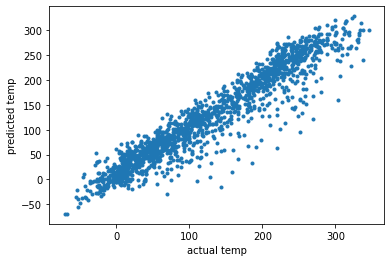

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train, test = train_test_split(d, test_size = 0.2, random_state = 0)
train_cols = ["hr", "dew", "pressure", "winddir", "windspeed"]
target = "temp"
train = train[train_cols + [target]]
train = train.dropna()
lr = LinearRegression(fit_intercept = False, normalize = True)
lr.fit(train[train_cols], train['temp'])
print("R2 on train data:", lr.score(train[train_cols], train[target]))
print("R2 on test data:", lr.score(test[train_cols], test[target]))
plt.plot(test[target], lr.predict(test[train_cols]), '.')
plt.xlabel("actual temp")
plt.ylabel("predicted temp")
plt.show()

we have a somewhat good prediction here with an R^2=0.9. R^2 is also pretty close on test vs train data, hinting at overfitting not being a big issue here.  
But what if I remove dew from our predictors:

R2 on train data: 0.03337739328683642
R2 on test data: 0.03962941792621466


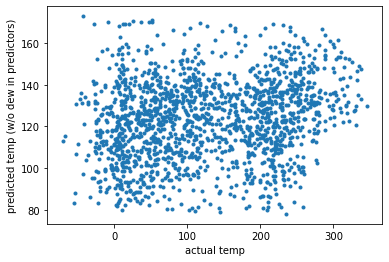

In [23]:
train_cols = ["hr", "pressure", "winddir", "windspeed"]
target = "temp"
train = train[train_cols + [target]]
train = train.dropna()
lr = LinearRegression(fit_intercept = False, normalize = True)
lr.fit(train[train_cols], train['temp'])
print("R2 on train data:", lr.score(train[train_cols], train[target]))
print("R2 on test data:", lr.score(test[train_cols], test[target]))
plt.plot(test[target], lr.predict(test[train_cols]), '.')
plt.xlabel("actual temp")
plt.ylabel("predicted temp (w/o dew in predictors)")
plt.show()

yup, removing dew, there isn't much left that can be regressed linearly. How about if I generate polynomial features:

R2 on train data: 0.36182683043554575
R2 on test data: 0.370294861308485


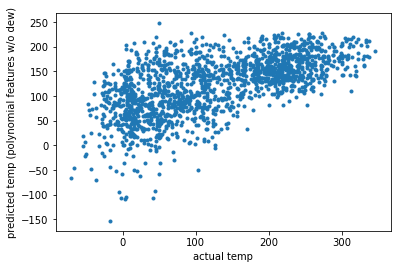

In [24]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree = 3)
train_poly = pf.fit_transform(X= train[train_cols], y=train[target])
test_poly = pf.transform(test[train_cols])
lr.fit(train_poly, train[target])
print("R2 on train data:", lr.score(train_poly, train[target]))
print("R2 on test data:", lr.score(test_poly, test[target]))
plt.plot(test[target], lr.predict(test_poly), '.')
plt.xlabel("actual temp")
plt.ylabel("predicted temp (polynomial features w/o dew)")
plt.show()

polynomial features helped but not as much. Let's check the residuals:

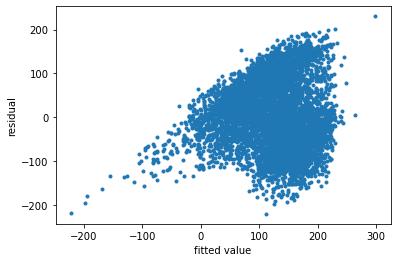

In [25]:
y_pred = lr.predict(train_poly)
y = train[target]
res = y_pred - y
plt.plot(y_pred, res, '.')
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.show()

<h4> This tells us that the relationship between the predictors and target is not linear! Hence, our poor performance! Maybe an svm with gaussian kernel will give better results. But let's move on to the next section.</h4>

ok, now it's time to start digging into year-by-year ISD data from selected sensors. If you remember, we decided to focus on some 2k sensors that are clustered as Oceania!

<h2> Looking at ISD data files from Oceania over a period of multiple years</h2>

first modifying our data_download function to accept a list of sensor IDs:

In [26]:
import urllib.request
import os
from tqdm.notebook import tqdm

my_sensors['sensor_id'] = my_sensors['USAF'].astype(str) + '-' + my_sensors['WBAN'].astype(str)

def download_and_reformat_isd_for_year_by_sensor_list(year, datadir, sensor_list, maxnum = float("inf")):
    ### Download all the data for a given year and store in the specified directory
    # PARAMETERS:
    # ------------
    # year: year number e.g. 2021
    # datadir: output directory. This will be appended by the year in the function
    # sensor_list: a list of usaf-wban sensor ids that will be used to identify sensor filenames
    # maxnum: (optional) maximum number of files to download; if not provided or bigger than
    url = f"https://www1.ncdc.noaa.gov/pub/data/noaa/isd-lite/{year}"
    datadir = f"{datadir}/{year}"
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    filenames = [f"{sensor_id}-{year}.gz" for sensor_id in sensor_list[:min(maxnum, len(sensor_list))]]
    filenames = set(filenames)
    print(f"downloading {len(set(filenames))}...")
    for fname in tqdm(filenames):
        #print(fname)
        try:
            urllib.request.urlretrieve(f"{url}/{fname}", f"{datadir}/{fname}")
            os.system(f"zcat {datadir}/{fname} | sed -r 's/ +/,/g' > {datadir}/{fname[:-3]}")
            os.remove(f"{datadir}/{fname}")
        except Exception as e:
            print(f"skipping {fname} for {year}: {e}")
    
download_dir = "data/my_sensors"
years = range(1901,2021)
for year in tqdm(years):
    sensor_ids = my_sensors[(my_sensors['begin_year'] <= year) & (my_sensors['end_year'] >= year)]
    sensor_list = sensor_ids['sensor_id']
    ### UNCOMMENT THE LINE BELOW TO DOWNLOAD THE DATA FOR 1901-2020 FOR SELECTED SENSORS
    #download_and_reformat_isd_for_year_by_sensor_list(year, download_dir, sensor_list)

<ipython-input-26-b1a1742ceeac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_sensors['sensor_id'] = my_sensors['USAF'].astype(str) + '-' + my_sensors['WBAN'].astype(str)


Then I'll replace the missing values (-9999) with NA in all these downloaded files using "sed".

In [27]:
for y in range(1901, 2021):
    fnames = f"data/my_sensors/{y}/*"
    ### UNCOMMENT THE NEXT LINE TO RUN THE SED COMMAND REPLACING MISSING VALUES WITH "NA"
    os.system("sed -i 's/-9999/NA/g' " + fnames)

Now I will use "awk" to compute the annual temperature mean and variance and store all values (per year per sensor) into one comma-separated file.

In [29]:
import subprocess
import glob

print(os.getcwd())
for sensor_id in tqdm(my_sensors['sensor_id']):
    fnames = glob.glob(f"data/my_sensors/*/{sensor_id}-*")
    for fname in fnames:
        year = fname[-4:]
        awk_vars = f"-v year={year} -v sensor={sensor_id} -F,"
        awk_command = "awk " + awk_vars + " '{total+=$5; sq+=($5*$5); if($i != \"NA\"){count+=1} ;}END{printf sensor \",\" year \",\" sq/count-(total/count)^2 \",\" total/count ; print \"\"}' " + os.getcwd()+"/"+fname + " >> my_sensors_yearly_temp_stats.csv"
        ### UNCOMMENT THE NEXT TWO LINES TO AGGREGATE SENSOR DATA BY COMPUTING MEAN AND VARIANCE OF THE YEARLY TEMPERATURES
        #proc = subprocess.Popen(awk_command, shell = True)
        #proc.communicate()

/home/armen/noaa


Let's take a look at the summary file we have created:

In [30]:
y = pd.read_csv("my_sensors_yearly_temp_stats.csv", header = None, names = ["sensor", "year", "temp_var", "temp_mean"])
y.head()

,sensor,year,temp_var,temp_mean
0,010010-99999,2020,1958.52,4.10029
1,010010-99999,1937,2565.80,3.88280
2,010010-99999,1978,4102.42,-15.95470
3,010010-99999,1988,4603.24,-24.06230
4,010010-99999,2012,1784.34,2.67183


For a better view, I'll randomly select 10 sensors, and look at their mean of annual temperature. There seems to be a lot of vartiation in the data with some outliers:

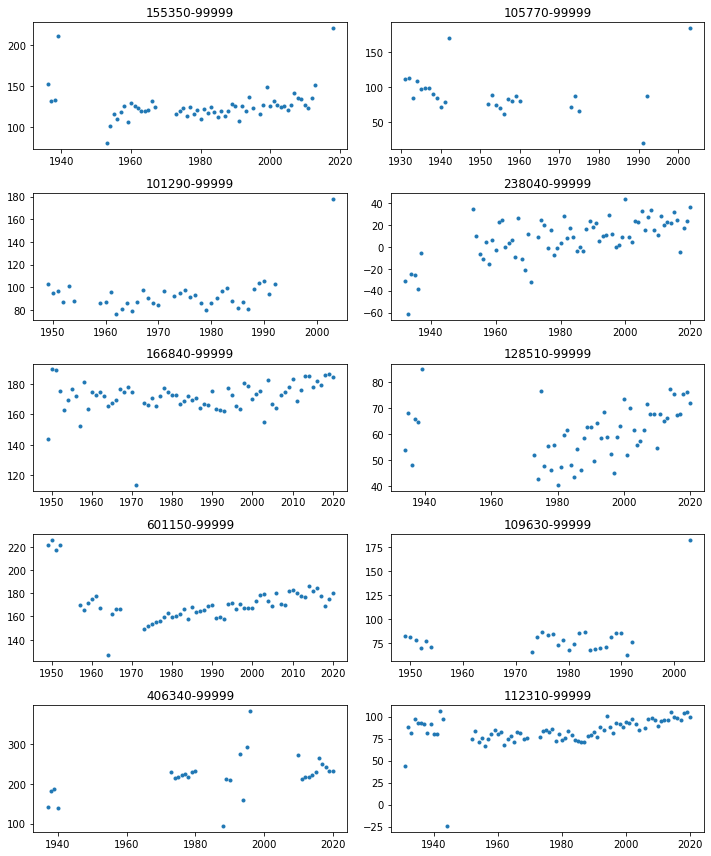

In [31]:
rows, cols = 5, 2
np.random.seed(14)
sensors = np.random.choice(y['sensor'].unique(), rows * cols)

fig, ax = plt.subplots(rows, cols, figsize = (10,12))
for i in range(rows):
    for j in range(cols):
        ax[i][j].plot("year", "temp_mean", ".", data = y[y["sensor"]==sensors[i*cols + j]])
        ax[i][j].title.set_text(sensors[i*cols+j])
plt.tight_layout()

Let's transform our dataframe, so that columns represent years (features) and rows represent sensors:

In [32]:
y2 = y.pivot(index = "sensor", columns = "year", values = "temp_mean")
y2.head()

year,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
sensor,,,,,,,,,,,,,,,,,,,,,
010010-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.80693,2.67183,0.647218,20.58670,10.0738,21.9599,15.82810,20.03210,8.22182,4.10029
010050-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010100-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.95120,37.17310,47.179100,48.24100,51.3073,49.6571,36.08540,44.08310,38.08330,50.05360
010230-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.02780,5.18749,22.981400,16.09170,27.6387,13.7624,9.68704,6.49371,4.73522,26.09580
010280-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.51461,6.22858,5.422910,6.59493,4.0217,18.3538,6.67141,9.69780,-4.98402,-6.92502


There is a lot of variation in between years for each sensor. Can we use some smoothing method to get a more clear picture:

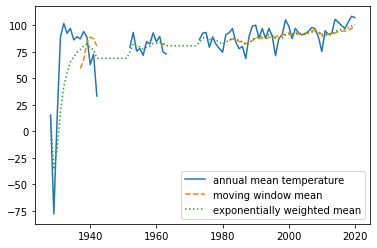

In [34]:
np.random.seed(10)
select_sensor = np.random.choice(y2.index, 1)[0]
plt.plot(y2.columns, y2[y2.index==select_sensor].transpose(), label = "annual mean temperature")
plt.plot(y2.columns, y2[y2.index==select_sensor].transpose().rolling(window = 10).mean(), '--', label = "moving window mean")
plt.plot(y2.columns, y2[y2.index==select_sensor].transpose().ewm(span = 10).mean(), ':', label = "exponentially weighted mean")
plt.legend()
#print(y2[y2.index==select_sensor].transpose().ewm(span = 10).mean())

Seems like moving average and exponentially wieghted averaging are showing some overall trend. I'll use exponentially weighted method to replace the missing values, and then use an RNN for regression. However, since I'm smoothing the values, I do not expect my RNN to have a good prediction of the year-to-year variance but it should be able to predict the overall trend in large spans of time. 

In [115]:
data = y2.transpose().ewm(span = 10).mean().transpose()
#print(data.shape)
data.head()

year,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
sensor,,,,,,,,,,,,,,,,,,,,,
010010-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.271340,5.616678,4.712906,7.599660,8.049581,10.579088,11.533564,13.078898,12.195725,10.723734
010050-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.305267,61.305267,61.305267,61.305267,61.305267,61.305267,61.305267,61.305267,61.305267,61.305267
010100-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.161199,43.708343,44.339559,45.049067,46.187131,46.818126,44.866488,44.724040,43.516536,44.705171
010230-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.624263,16.180472,17.417311,17.176242,19.078823,18.112070,16.580076,14.746024,12.925742,15.320444
010280-99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.374632,0.008206,0.992952,2.011709,2.377225,5.282467,5.535031,6.291970,4.241631,2.211203


In [245]:
def create_model(window_size):

    initializers = "glorot_normal"
    activation_name = 'relu'
    model = tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(128, kernel_initializer = initializers, activation = activation_name, input_shape = (None, window_size), return_sequences = True),
      #tf.keras.layers.SimpleRNN(256, kernel_initializer = initializers, activation = activation_name, return_sequences = True),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.SimpleRNN(128, kernel_initializer = initializers, activation = activation_name, return_sequences = False),
    ])

    model.add(tf.keras.layers.Dense(110, activation = 'linear', kernel_initializer = initializers))
    loss_function = 'mse'
    optimizer = 'adam'
    model.summary()
    model.compile(optimizer, loss_function)
    return model

In the rest, I will create overlapping windows with a look-ahead distance and try prediction of the temperature for $year_{15}$ from years $year_1, year_2, year3, ..., year_{10}$. Followed by analysis of the learning (loss function value trend, overfit, etc).  
I have not completed this part, because my only experience in time-series analysis using deep learning goes back to a personal project a few years ago, and I was not able to remind myself of the details in the time given. I will conclude this exercise here.